In [1]:
# enable autoreload
%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload

import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION']='python'

import scvi
scvi.settings.seed = 0
import scanpy as sc
import anndata as ad
import torch
import numpy as np
import pandas as pd
import json
from datetime import datetime
from scipy.sparse import csr_matrix
torch.set_float32_matmul_precision('medium')
import warnings
warnings.simplefilter("ignore", UserWarning)



/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 0


In [2]:
# import from scfair-reproducibility
from dis2pm_dev.scfair_reproducibility.benchmark_VAE.vi import VI
from dis2pm_dev.scfair_reproducibility.evaluation.metrics import *

# import from scib_metrics
from dis2pm_dev.scfair_reproducibility.scib_metrics_dev.src.scib_metrics.benchmark import Benchmarker


In [3]:
import biolord

In [4]:
from dis2p.dis2pvae import *
from dis2p.dis2pvi import *
from dis2p.ood import *
from dis2p.trainingplan import *
from dis2p.utils import *

import dis2p.dis2pvae_cE as dvae
import dis2p.dis2pvi_cE as dvi

## Train Dis2p

In [5]:
def create_cats_idx(adata, cats):
    # create numerical index for each attr in cats

    for i in range(len(cats)):
        values = list(set(adata.obs[cats[i]]))

        val_to_idx = {v: values.index(v) for v in values}

        idx_list = [val_to_idx[v] for v in adata.obs[cats[i]]]

        adata.obs[cats[i] + '_idx'] = pd.Categorical(idx_list)

    return adata

# preprocess dataset
adata = scvi.data.heart_cell_atlas_subsampled()
#adata = sc.read("/nfs/team205/sm58/packages/dis2p_trials/scfair/data/hca_subsampled_20k.h5ad")
sc.pp.filter_genes(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)

# specify name of dataset 
data_name = 'HeartAtlas'

# specify attributes
cats = ['cell_type', 'cell_source', 'gender', 'region']

# create numerical index for each attr in cats
create_cats_idx(adata, cats)

# save adata
# adata.write_h5ad('data/heart_preprocessed1200.h5ad')

today = datetime.today().strftime('%Y-%m-%d')

INFO     File data/hca_subsampled_20k.h5ad already downloaded                                                      


In [ ]:
# #degub
# import scvi
# scvi.settings.seed = 0
# import scanpy as sc

# adata = scvi.data.heart_cell_atlas_subsampled()
# sc.pp.filter_genes(adata, min_counts=3)
# adata.layers["counts"] = adata.X.copy()
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# adata.raw = adata
# sc.pp.highly_variable_genes(
#     adata,
#     n_top_genes=1200,
#     subset=True,
#     layer="counts",
#     flavor="seurat_v3",
# )

In [12]:
print(today)
today = "2024-01-12"

2024-01-12


In [10]:
# train params
epochs = 80
batch_size = 128
cf_weight = 1
beta = 1
clf_weight = 50
adv_clf_weight = 10
adv_period = 1
n_cf = 1

# architecture params
n_layers=1

train_dict = {'max_epochs': epochs, 'batch_size': batch_size, 'cf_weight': cf_weight,
              'beta': beta, 'clf_weight': clf_weight, 'adv_clf_weight': adv_clf_weight,
              'adv_period': adv_period, 'n_cf': n_cf}

module_name = 'dis2p'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:

    Dis2pVI.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = Dis2pVI(adata, n_layers=n_layers)
    model.train(**train_dict)
    model.save(f"{pre_path}/{model_name}")

INFO     File                                                                                                      
         models/dis2p/2024-01-12,dis2p,HeartAtlas,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_we
         ight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                 


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [23]:
# load model
pre_path = f'models/dis2p'
model_name = f'{today},dis2p,HeartAtlas,n_layers=1,max_epochs={epochs},batch_size=128,cf_weight=1,beta=1,clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1'
model = Dis2pVI.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)



INFO     File                                                                                                      
         models/dis2p/2024-01-12,dis2p,HeartAtlas,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,clf_we
         ight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                                 


In [24]:
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
#warnings.simplefilter('ignore', category=NumbaWarning)

---UMAP for dis2p_Z_0---


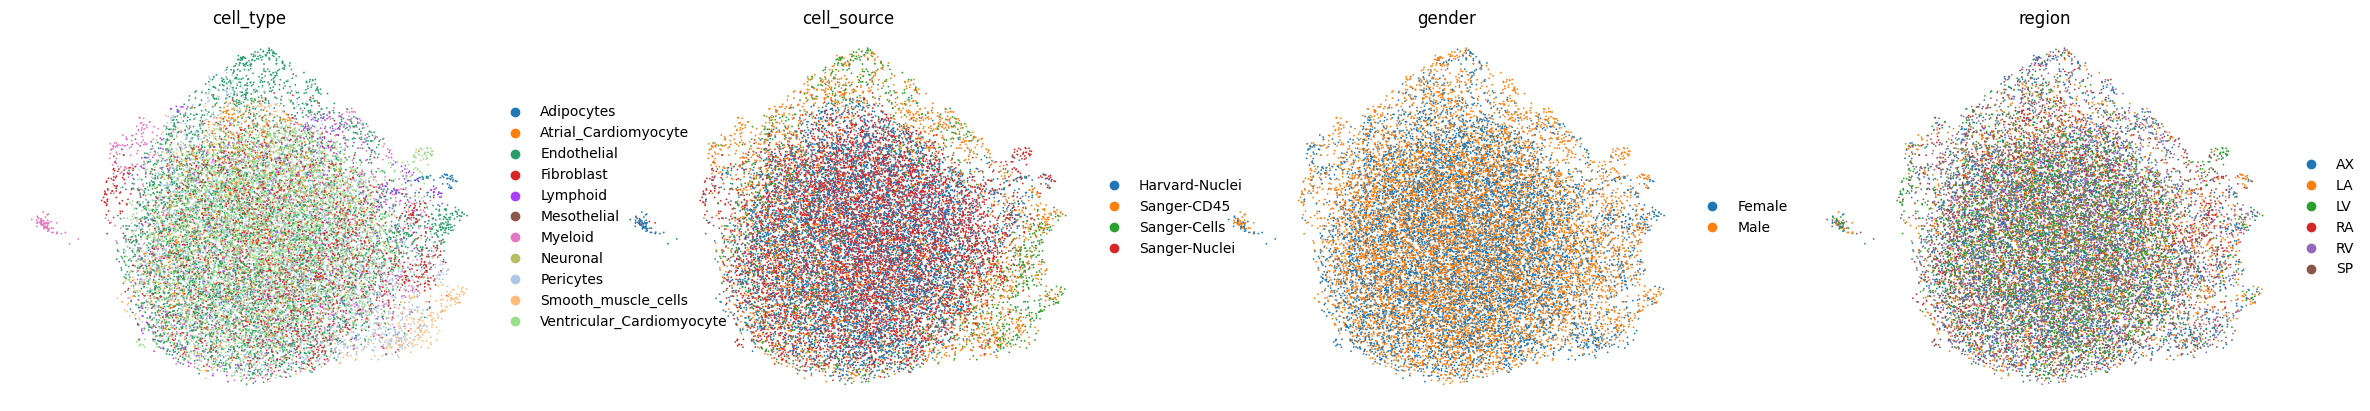

---UMAP for dis2p_Z_1---


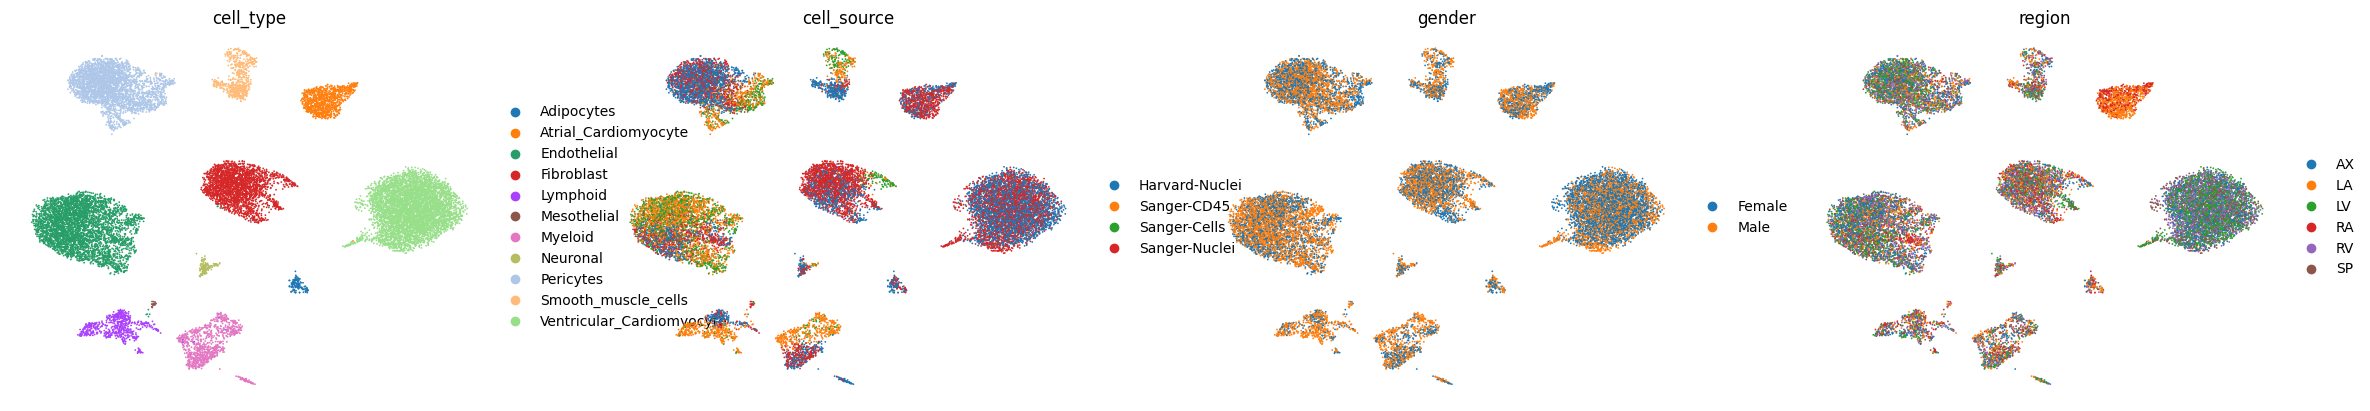

---UMAP for dis2p_Z_2---


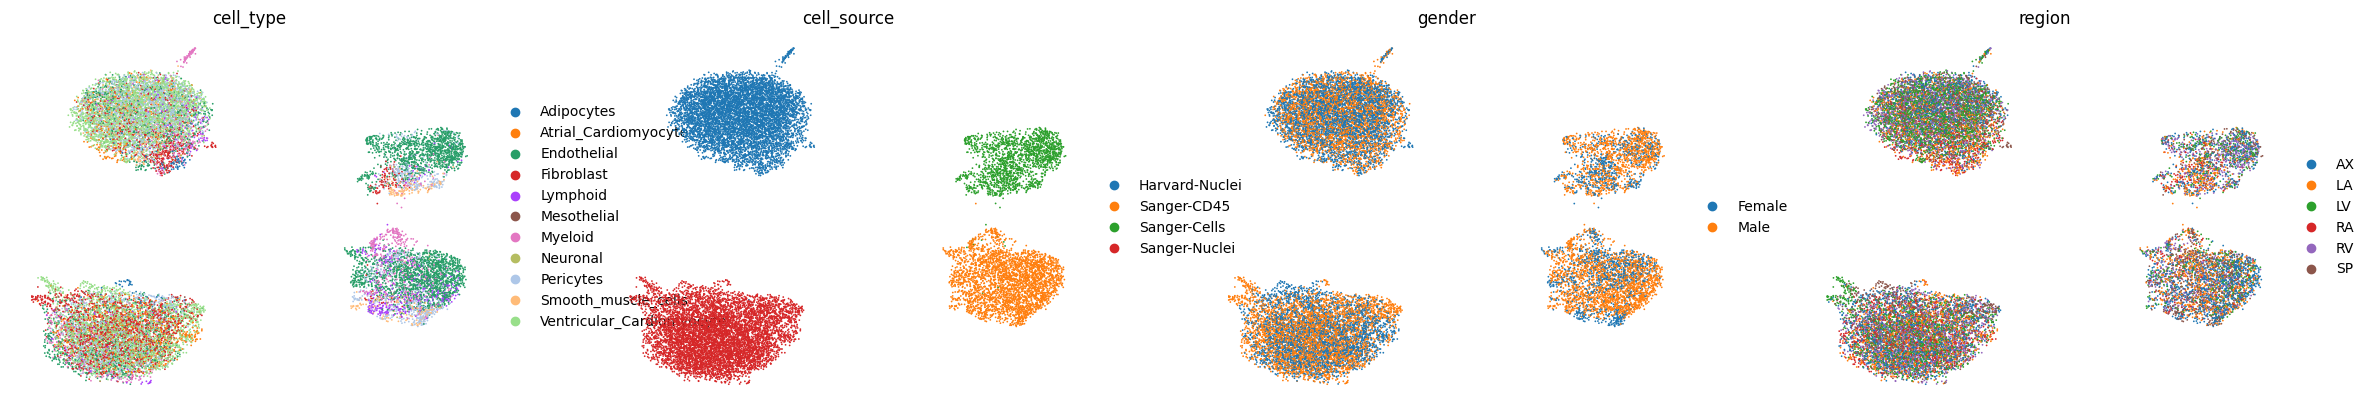

---UMAP for dis2p_Z_3---


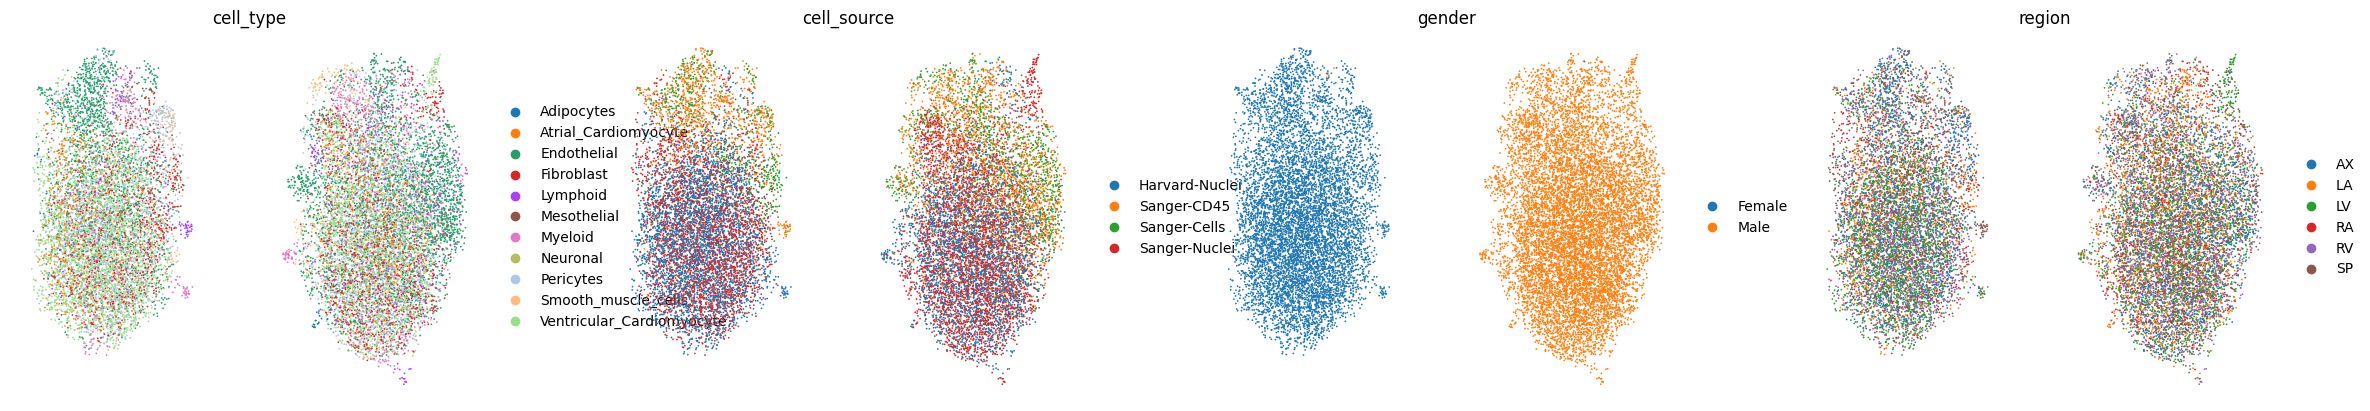

---UMAP for dis2p_Z_4---


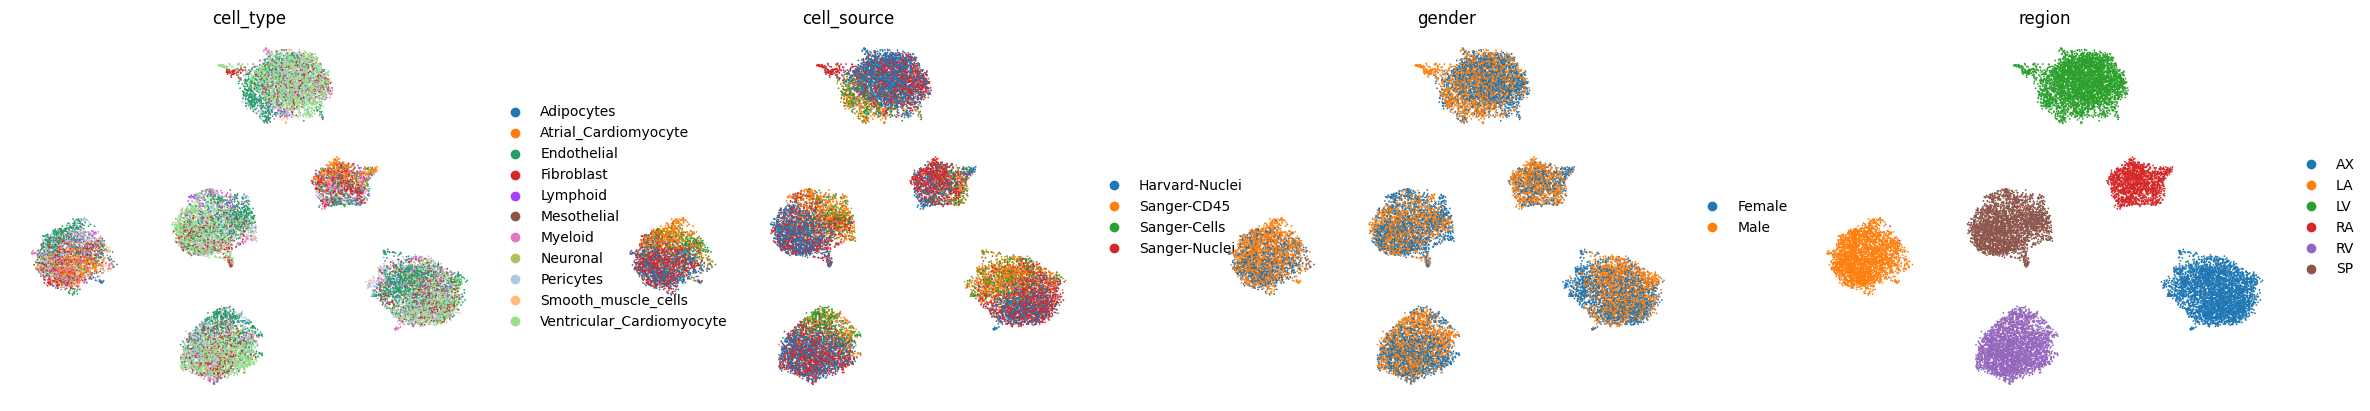

In [25]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## Train dis2p_cE version

In [16]:
module_name = 'dis2p_cE'
pre_path = f'models/{module_name}'
if not os.path.exists(pre_path):
    os.makedirs(pre_path)

# specify a name for your model
model_name =  f'{today},{module_name},{data_name},' + f'n_layers={n_layers},' + ','.join(k + '=' + str(v) for k, v in train_dict.items())

# load model (if trained before)
try:
    model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# trains the model (if not trained before) and save it into: pre_path + model_name
except:
    dvi.Dis2pVI_cE.setup_anndata(
        adata,
        layer='counts',
        categorical_covariate_keys=cats,
        continuous_covariate_keys=[]
    )
    model = dvi.Dis2pVI_cE(adata, n_layers=n_layers)
    model.train(**train_dict)


INFO     File                                                                                                      
         models/dis2p_cE/2024-01-12,dis2p_cE,HeartAtlas,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,
         clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                           


In [27]:
model.save(f"{pre_path}/{model_name}")

In [17]:
# load model
model = dvi.Dis2pVI_cE.load(f"{pre_path}/{model_name}", adata=adata)

# Z_0
adata.obsm[f'dis2p_cE_Z_0'] = model.get_latent_representation(nullify_cat_covs_indices=[s for s in range(len(cats))], nullify_shared=False)

for i in range(len(cats)):
    null_idx = [s for s in range(len(cats)) if s != i]
    # Z_i
    adata.obsm[f'dis2p_cE_Z_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=null_idx, nullify_shared=True)
    # Z_{-i}
    adata.obsm[f'dis2p_cE_Z_not_{i+1}'] = model.get_latent_representation(nullify_cat_covs_indices=[i], nullify_shared=False)

INFO     File                                                                                                      
         models/dis2p_cE/2024-01-12,dis2p_cE,HeartAtlas,n_layers=1,max_epochs=80,batch_size=128,cf_weight=1,beta=1,
         clf_weight=50,adv_clf_weight=10,adv_period=1,n_cf=1/model.pt already downloaded                           


---UMAP for dis2p_cE_Z_0---


/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team205/sm58/analysis/scfair_analysis/scfair_analysis_env/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team205/s

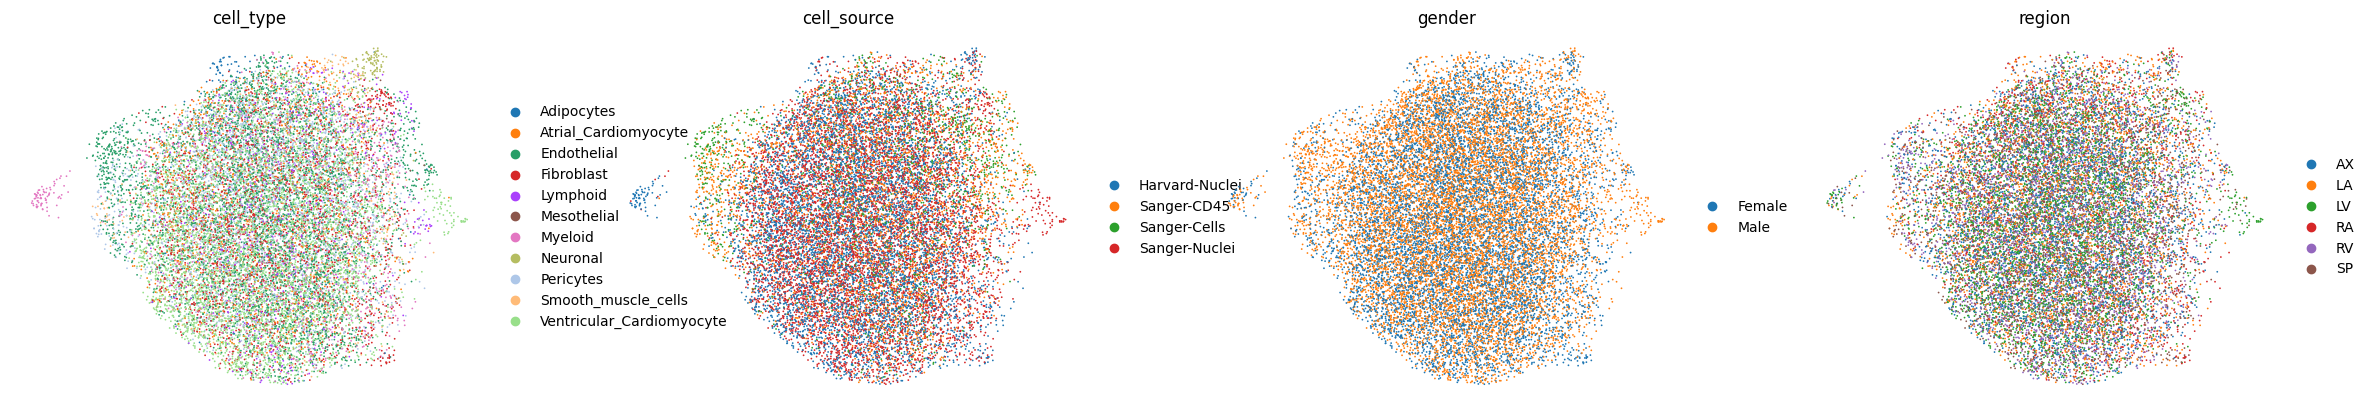

---UMAP for dis2p_cE_Z_1---


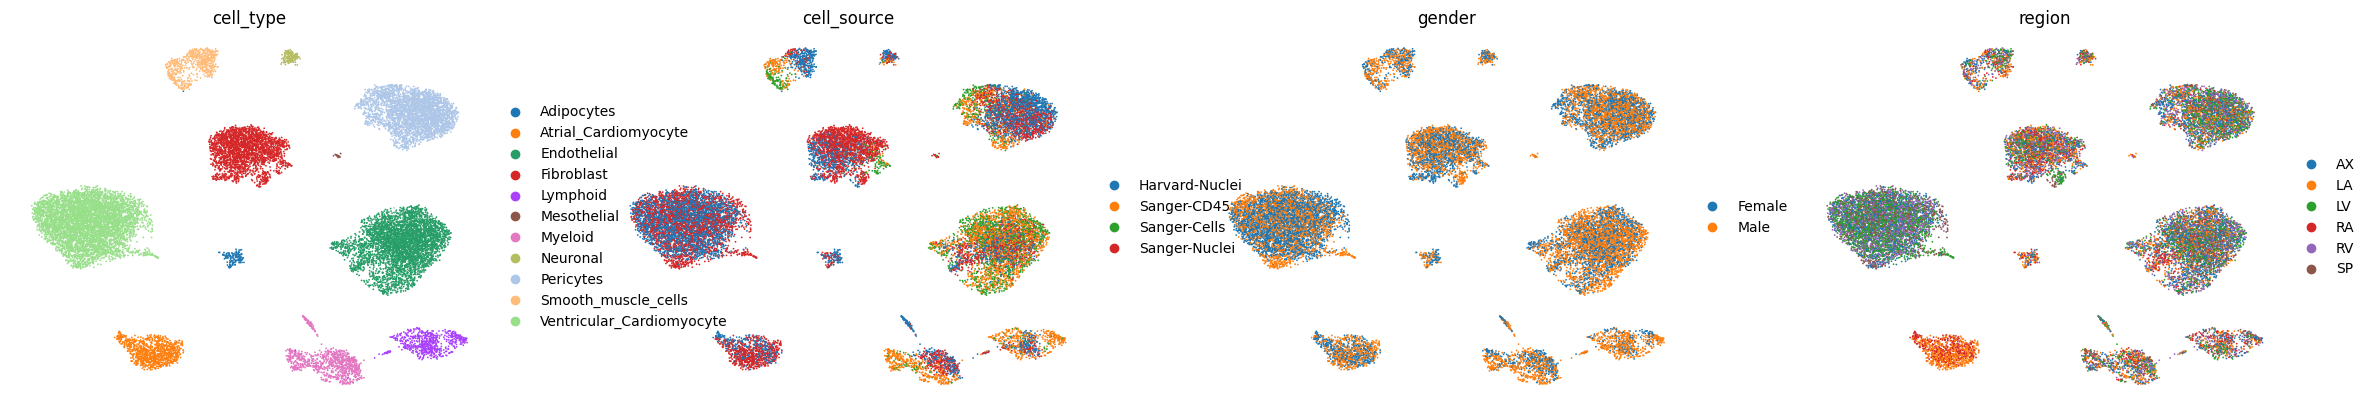

---UMAP for dis2p_cE_Z_2---


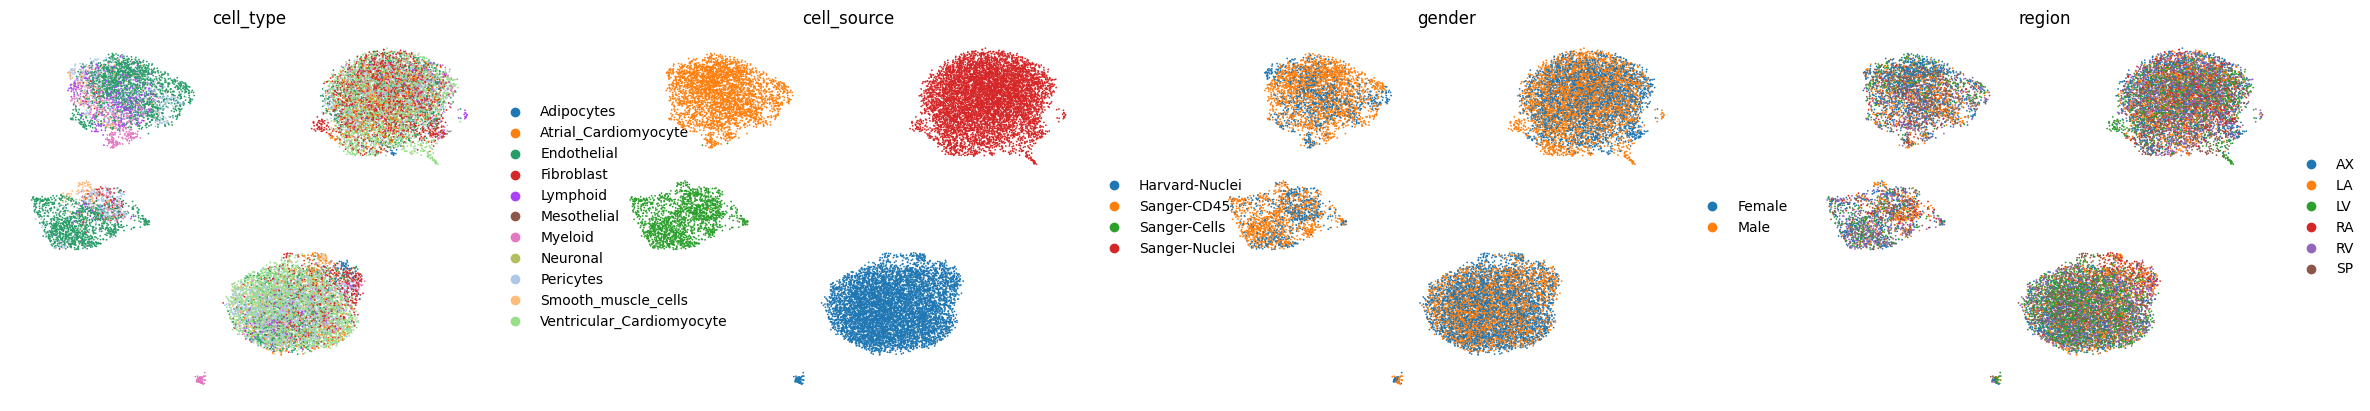

---UMAP for dis2p_cE_Z_3---


In [ ]:
for i in range(len(cats) + 1):  # loop over all Z_i

    latent_name = f'dis2p_cE_Z_{i}'

    print(f"---UMAP for {latent_name}---")

    sc.pp.neighbors(adata, use_rep=f"{latent_name}")
    sc.tl.umap(adata)

    sc.pl.umap(
        adata,
        color=cats,
        ncols=len(cats),
        frameon=False,
    )

## We notice that the UMAPs of dis2p and dis2p_cE looks almost identical

## Now let's train Biolord

In [6]:
biolord.Biolord.setup_anndata(
    adata=adata,
    ordered_attributes_keys=[],
    categorical_attributes_keys=cats,
    layer="counts"
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [7]:
# params in these cells are taken from here: https://biolord.readthedocs.io/en/latest/tutorials/biolord_omics.html#instantiate-a-biolord-model
module_params = {
    "decoder_width": 512,
    "decoder_depth": 6,
    "attribute_nn_width": 256,
    "attribute_nn_depth": 2,
    "unknown_attribute_noise_param": 1e0,
    "seed": 42,
    "n_latent_attribute_ordered": 16,
    "n_latent_attribute_categorical": 16,
    "gene_likelihood": "poisson",
    "reconstruction_penalty": 1e1,
    "unknown_attribute_penalty": 1e0,
    "attribute_dropout_rate": 0.1
}
model = biolord.Biolord(
    adata=adata,
    n_latent=128,
    model_name="kang_biolord_new",
    module_params=module_params,
)

Global seed set to 42


In [10]:
trainer_params = {
    "n_epochs_warmup": 0,
    "latent_lr": 1e-4,
    "latent_wd": 1e-4,
    "decoder_lr": 1e-4,
    "decoder_wd": 1e-4,
    "attribute_nn_lr": 1e-2,
    "attribute_nn_wd": 4e-8,
    "step_size_lr": 45,
    "cosine_scheduler": True,
    "scheduler_final_lr": 1e-5,
}
model.train(
    max_epochs=400,
    batch_size=256,
    plan_kwargs=trainer_params,
    early_stopping=True,
    enable_checkpointing=False,
    early_stopping_patience=45,
    check_val_every_n_epoch=10,
    num_workers=1,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


TypeError: DataLoader.__init__() got an unexpected keyword argument 'use_gpu'

In [6]:
vae = scvi.model.SCVI.load("models/scVI", adata=adata)
adata.obsm["scVI"] = vae.get_latent_representation()

lvae_new = scvi.model.SCANVI.load("models/scANVI_new", adata=adata)
adata.obsm["scANVI"] = lvae_new.get_latent_representation()

INFO     No backup URL provided for missing file models/scVI/model.pt                                              


ValueError: Failed to load model file at models/scVI/model.pt. If attempting to load a saved model from <v0.15.0, please use the util function `convert_legacy_save` to convert to an updated format.